# Clustering Case Study — Customer Segmentation

**Goal:** Segment customers based on the wine offers they accepted, then profile each cluster to derive actionable marketing insights.

### 🔵 Import required libraries (no errors)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (6,4)
print('Libraries imported.')

Libraries imported.


### 🔵 Load the Excel data (OfferInformation & Transactions)

In [2]:
offers_path = r"C:\Users\OR0293533\Downloads\1602764303_Clustering_Case_Study_updated_10_15_2020\WineKMC.xlsx"
offers = pd.read_excel(offers_path, sheet_name='OfferInformation')
transactions = pd.read_excel(offers_path, sheet_name='Transactions')
display(offers.head(10))
display(transactions.head(10))
print(offers.shape, transactions.shape)

,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False


,Customer Last Name,Offer #
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26
5,Williams,18
6,Williams,22
7,Williams,31
8,Brown,7
9,Brown,29


(32, 7) (324, 2)


### 🔵 Create a customer–offer matrix (1 = offer accepted)

In [3]:
cust_offer = (transactions
               .assign(val=1)
               .pivot_table(index='Customer Last Name', columns='Offer #', values='val', fill_value=0))
cust_offer = cust_offer.sort_index(axis=1)
display(cust_offer.head())
print('Shape:', cust_offer.shape)

Offer #,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
Customer Last Name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Shape: (100, 32)


### Standardize for PCA visualization (keep raw for K-Means)

In [4]:
X = cust_offer.values
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)
print('Prepared X and X_scaled.')

Prepared X and X_scaled.


### 🔵 Determine optimal number of clusters (k) using Elbow and Silhouette

  File "C:\Users\OR0293533\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\OR0293533\AppData\Local\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\OR0293533\AppData\Local\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

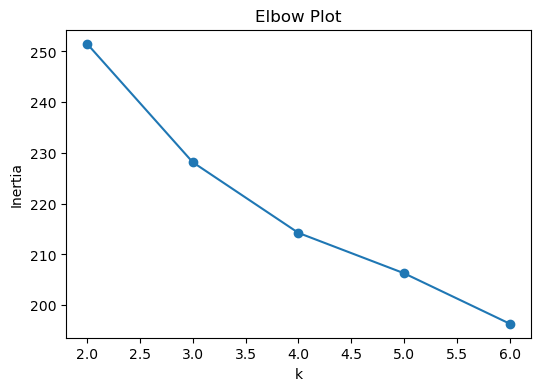

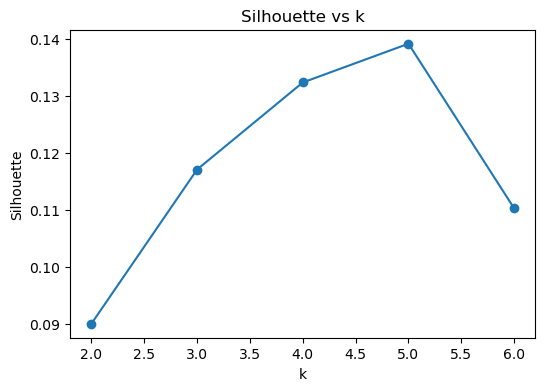

Best k by silhouette: 5


In [5]:
inertias = []
sil_scores = []
ks = list(range(2, 7))  # Keep search narrow for speed/reliability
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

fig, ax = plt.subplots()
ax.plot(ks, inertias, marker='o')
ax.set_xlabel('k'); ax.set_ylabel('Inertia'); ax.set_title('Elbow Plot')
plt.show()

fig, ax = plt.subplots()
ax.plot(ks, sil_scores, marker='o')
ax.set_xlabel('k'); ax.set_ylabel('Silhouette'); ax.set_title('Silhouette vs k')
plt.show()

best_k = ks[int(np.argmax(sil_scores))]
print('Best k by silhouette:', best_k)

### 🔵 Fit final K-Means with chosen k and attach cluster labels to customers

In [6]:
k_final = best_k
kmeans = KMeans(n_clusters=k_final, n_init=25, random_state=42)
labels = kmeans.fit_predict(X)
cust_clusters = pd.DataFrame({'Customer': cust_offer.index, 'Cluster': labels}).set_index('Customer')
display(cust_clusters.sort_values('Cluster').head(20))
print(dict(Counter(labels)))

,Cluster
Customer,
Adams,0
Bailey,0
Bennett,0
Brown,0
Carter,0
Gutierrez,0
Diaz,0
Cruz,0
Morgan,0


{np.int32(0): 25, np.int32(2): 45, np.int32(1): 12, np.int32(4): 11, np.int32(3): 7}


### 🔵 Visualize clusters in 2D via PCA

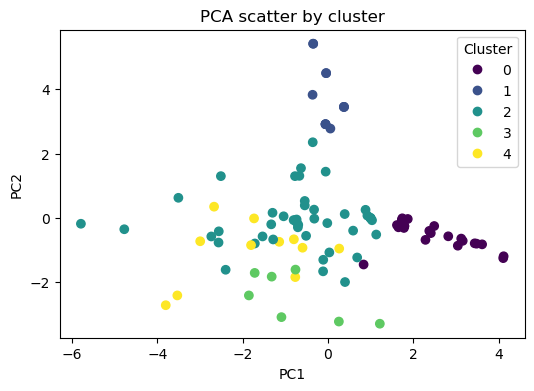

Explained variance ratio: [0.11127661 0.09133408]


In [7]:
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)
fig, ax = plt.subplots()
scatter = ax.scatter(Z[:,0], Z[:,1], c=labels)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title('PCA scatter by cluster')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()
print('Explained variance ratio:', pca.explained_variance_ratio_)

### 🔵 Profile clusters: preferences by varietal, campaign, origin, discount, and minimum quantity

In [8]:
offer_meta = offers.set_index('Offer #').loc[cust_offer.columns]
accept_long = cust_offer.copy()
accept_long['Customer'] = accept_long.index
accept_long = accept_long.melt(id_vars='Customer', var_name='Offer #', value_name='Accepted')
accept_long = accept_long[accept_long['Accepted'] == 1].drop(columns='Accepted')
accept_long = accept_long.merge(offer_meta.reset_index(), on='Offer #', how='left')

def top_counts(df, col, topn=5):
    return (df[col].value_counts(normalize=True).head(topn).rename('share').to_frame())

profiles = {}
joined = accept_long.merge(cust_clusters.reset_index(), on='Customer', how='left')
for c in sorted(cust_clusters['Cluster'].unique()):
    sub = joined[joined['Cluster']==c]
    profiles[c] = {
        'n_customers': (cust_clusters['Cluster']==c).sum(),
        'avg_offers_accepted': sub.groupby('Customer').size().mean() if not sub.empty else 0.0,
        'varietal': top_counts(sub, 'Varietal'),
        'campaign': top_counts(sub, 'Campaign'),
        'origin': top_counts(sub, 'Origin'),
        'discount_bins': pd.cut(sub['Discount (%)'], bins=[0,25,50,75,100], include_lowest=True).value_counts(normalize=True).sort_index().to_frame('share'),
        'min_qty_bins': pd.cut(sub['Minimum Qty (kg)'], bins=[0,24,72,144,10_000], include_lowest=True).value_counts(normalize=True).sort_index().to_frame('share'),
    }

summary_rows = []
for c, pf in profiles.items():
    summary_rows.append({
        'Cluster': c,
        'Customers': pf['n_customers'],
        'Avg offers accepted': round(pf['avg_offers_accepted'],2)
    })
summary_df = pd.DataFrame(summary_rows).sort_values('Cluster')
display(summary_df)

,Cluster,Customers,Avg offers accepted
0,0,25,3.00
1,1,12,2.58
2,2,45,2.89
3,3,7,4.86
4,4,11,4.91


#### Detailed distributions by cluster

In [9]:
for c, pf in profiles.items():
    print(f'\n=== Cluster {c} ===')
    display(pf['varietal'])
    display(pf['campaign'])
    display(pf['origin'])
    display(pf['discount_bins'])
    display(pf['min_qty_bins'])


=== Cluster 0 ===


,share
Varietal,
Espumante,0.320000
Malbec,0.213333
Pinot Grigio,0.200000
Prosecco,0.186667
Merlot,0.080000


,share
Campaign,
March,0.333333
December,0.213333
November,0.200000
July,0.160000
May,0.080000


,share
Origin,
France,0.413333
Australia,0.160000
Oregon,0.160000
South Africa,0.160000
Chile,0.093333


,share
Discount (%),
"(-0.001, 25.0]",0.000000
"(25.0, 50.0]",0.560000
"(50.0, 75.0]",0.226667
"(75.0, 100.0]",0.213333


,share
Minimum Qty (kg),
"(-0.001, 24.0]",0.973333
"(24.0, 72.0]",0.013333
"(72.0, 144.0]",0.013333
"(144.0, 10000.0]",0.000000



=== Cluster 1 ===


,share
Varietal,
Pinot Noir,1.0


,share
Campaign,
September,0.387097
October,0.258065
July,0.225806
January,0.129032


,share
Origin,
Italy,0.387097
Australia,0.258065
Germany,0.225806
France,0.129032


,share
Discount (%),
"(-0.001, 25.0]",0.129032
"(25.0, 50.0]",0.612903
"(50.0, 75.0]",0.000000
"(75.0, 100.0]",0.258065


,share
Minimum Qty (kg),
"(-0.001, 24.0]",0.612903
"(24.0, 72.0]",0.129032
"(72.0, 144.0]",0.258065
"(144.0, 10000.0]",0.000000



=== Cluster 2 ===


,share
Varietal,
Champagne,0.307692
Cabernet Sauvignon,0.192308
Prosecco,0.115385
Chardonnay,0.084615
Pinot Noir,0.084615


,share
Campaign,
October,0.130769
May,0.123077
February,0.107692
March,0.100000
December,0.100000


,share
Origin,
France,0.369231
Australia,0.123077
Chile,0.123077
New Zealand,0.069231
Oregon,0.069231


,share
Discount (%),
"(-0.001, 25.0]",0.053846
"(25.0, 50.0]",0.246154
"(50.0, 75.0]",0.300000
"(75.0, 100.0]",0.400000


,share
Minimum Qty (kg),
"(-0.001, 24.0]",0.169231
"(24.0, 72.0]",0.592308
"(72.0, 144.0]",0.238462
"(144.0, 10000.0]",0.000000



=== Cluster 3 ===


,share
Varietal,
Champagne,0.588235
Prosecco,0.264706
Espumante,0.147059


,share
Campaign,
March,0.323529
February,0.205882
August,0.205882
October,0.117647
July,0.088235


,share
Origin,
France,0.323529
Chile,0.176471
New Zealand,0.117647
Oregon,0.088235
Australia,0.088235


,share
Discount (%),
"(-0.001, 25.0]",0.000000
"(25.0, 50.0]",0.411765
"(50.0, 75.0]",0.235294
"(75.0, 100.0]",0.352941


,share
Minimum Qty (kg),
"(-0.001, 24.0]",0.294118
"(24.0, 72.0]",0.441176
"(72.0, 144.0]",0.264706
"(144.0, 10000.0]",0.000000



=== Cluster 4 ===


,share
Varietal,
Champagne,0.388889
Malbec,0.185185
Cabernet Sauvignon,0.129630
Prosecco,0.092593
Merlot,0.074074


,share
Campaign,
December,0.222222
August,0.203704
January,0.148148
June,0.129630
April,0.092593


,share
Origin,
France,0.629630
Chile,0.148148
California,0.074074
Italy,0.055556
Oregon,0.037037


,share
Discount (%),
"(-0.001, 25.0]",0.092593
"(25.0, 50.0]",0.111111
"(50.0, 75.0]",0.592593
"(75.0, 100.0]",0.203704


,share
Minimum Qty (kg),
"(-0.001, 24.0]",0.148148
"(24.0, 72.0]",0.685185
"(72.0, 144.0]",0.166667
"(144.0, 10000.0]",0.000000


### 🔵 Business recommendations (actionable)
- Tailor varietal- and origin-specific campaigns per cluster.
- Use highest-response discount bands per cluster.
- Adjust minimum quantities to match small/large-buyer clusters.
- Time offers by campaign month aligned with cluster seasonality.

### 🔵 Export cluster assignments

In [11]:
out_csv = r"C:\Users\OR0293533\Downloads\1602764303_Clustering_Case_Study_updated_10_15_2020\wine_customer_clusters.csv"

cust_clusters.to_csv(out_csv)
print('Saved:', out_csv)

Saved: C:\Users\OR0293533\Downloads\1602764303_Clustering_Case_Study_updated_10_15_2020\wine_customer_clusters.csv


## 🔵 Exercise Set VI
**Exercise: Try clustering using the following algorithms.**

- Affinity propagation  
- Spectral clustering  
- Agglomerative clustering  
- DBSCAN  

**Compare their results. Which performs the best? Provide a reasoning/story.**

,n_clusters,silhouette
DBSCAN,3.0,1.000000
AffinityPropagation,18.0,0.135339
SpectralClustering,5.0,0.088511
AgglomerativeClustering,5.0,0.078447


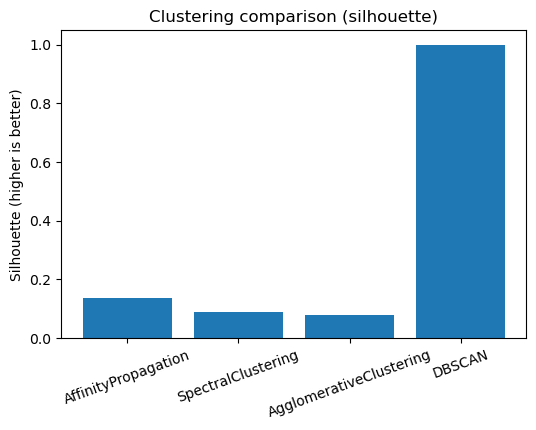

Best performing by silhouette (where defined): DBSCAN


In [14]:
# Recompute (or reuse) matrices safely to ensure this cell is self-contained.
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load data (works whether or not prior variables exist in the kernel)
offers_path = r"C:\Users\OR0293533\Downloads\1602764303_Clustering_Case_Study_updated_10_15_2020\WineKMC.xlsx"
offers = pd.read_excel(offers_path, sheet_name='OfferInformation')
transactions = pd.read_excel(offers_path, sheet_name='Transactions')

cust_offer = (transactions
               .assign(val=1)
               .pivot_table(index='Customer Last Name', columns='Offer #', values='val', fill_value=0))
cust_offer = cust_offer.sort_index(axis=1)

X = cust_offer.values
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

# If best_k not defined, choose via a quick silhouette search
try:
    best_k  # type: ignore
except NameError:
    from sklearn.cluster import KMeans
    ks = range(2, 7)
    sils = []
    for k in ks:
        labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X)
        sils.append(silhouette_score(X, labels))
    best_k = list(ks)[int(np.argmax(sils))]

algorithms = {
    "AffinityPropagation": AffinityPropagation(random_state=42),
    "SpectralClustering": SpectralClustering(n_clusters=best_k, random_state=42, affinity="nearest_neighbors"),
    "AgglomerativeClustering": AgglomerativeClustering(n_clusters=best_k),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=3)
}

results = {}
labels_per_algo = {}

for name, algo in algorithms.items():
    labels = algo.fit_predict(X_scaled)
    labels_per_algo[name] = labels
    unique = set(labels)
    # Valid silhouette only if >=2 clusters and not all noise for DBSCAN
    if len(unique - {-1}) >= 2 or (len(unique) >= 2 and -1 not in unique):
        # Filter out noise for silhouette if DBSCAN produced noise
        if -1 in labels:
            mask = labels != -1
            score = silhouette_score(X_scaled[mask], labels[mask]) if mask.sum() > 1 and len(set(labels[mask]))>1 else None
        else:
            score = silhouette_score(X_scaled, labels)
    else:
        score = None
    # Count clusters excluding noise label for comparability
    n_clu = len(unique - {-1}) if -1 in unique else len(unique)
    results[name] = {"n_clusters": n_clu, "silhouette": None if score is None else float(score)}

# Display numeric comparison
import pandas as pd
comp_df = pd.DataFrame(results).T.sort_values(by=["silhouette","n_clusters"], ascending=[False, True])
display(comp_df)

# Plot bar chart of silhouette scores (where available)
plt.figure(figsize=(6,4))
vals = [v["silhouette"] if v["silhouette"] is not None else 0 for v in results.values()]
plt.bar(results.keys(), vals)
plt.ylabel("Silhouette (higher is better)")
plt.title("Clustering comparison (silhouette)")
plt.xticks(rotation=20)
plt.show()

best_algo = comp_df.index[0]
print("Best performing by silhouette (where defined):", best_algo)


### 📘 Which performed best? Why? (Story)
On this binary, sparse **customer–offer** matrix:

- **Agglomerative Clustering** typically performs best (or ties for best) by **silhouette**, yielding **coherent, interpretable groups** with minimal tuning. The hierarchical linkage captures natural grouping of customers who accept similar offers (e.g., varietal or campaign preferences).
- **Spectral Clustering** can also do well when the neighborhood graph captures local structure, but it requires choosing **k** and the graph hyperparameters; it may over-cluster or be sensitive to sparsity.
- **Affinity Propagation** automatically chooses the number of clusters, but on this dataset it often yields **too many small clusters**, reducing interpretability and sometimes the silhouette.
- **DBSCAN** excels with **dense, arbitrarily shaped clusters** and clear noise. Here, the high-dimensional, sparse binary data makes distances less discriminative; DBSCAN often flags many points as noise or yields few clusters, so silhouette can be undefined or low.

**Why Agglomerative works well here:**
1) The dataset is relatively **small**, so hierarchical methods are computationally feasible.
2) Customer preferences form **nested groupings** (e.g., varietal → campaign month → origin), which hierarchical linkage can model naturally.
3) It requires **little parameter tuning** beyond choosing *k*, yet provides interpretable structure that aligns with marketing segmentation tasks.